In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import egurian as eg

Pré tratamento de dados e resultados preliminares:
O pré tratamento realiza o protocolo de PCA - LDA com todas as amostras, para obter informações prévias que podem ser úteis antes do ciclo de validação cruzada.





1- Importação da base de dados original, onde as observações (amostras) estão nas linhas e as variáveis (comprimentos de onda) estão nas colunas, e escolha da faixa espectral de interesse (400 a 1800 cm^-1).

In [2]:
# 1 - importação dos espectros originais | eliminação do cabeçário | passagem de todos os dados para tipo float | filtragem dos comprimentos de onda de interesse (400 a 1800 nm)
df = pd.read_csv("data.csv")
cabecario = df.iloc[:,0:4]
df = df.drop(cabecario.columns, axis = 1)
df.columns = df.columns.astype(float)
for i in df.columns:
  df[i] = df[i].astype(float)
df = df.iloc[:,290:997]

2 - Suavização dos espectros com a função LOEES. Realiza suavização atravéz de interpolação com repetidos cálculos de mínimos quadrados ponderados. Recebe como entrada os comprimentos de onda originais, os sinais originais, os novos comprimentos de onda, a faixa de valores usadas para a regressão polinomial e o grau do polinômio calculado em cada faixa.

In [4]:
# 2 - Utilização da função LOEES para suavisar os espectros originais, eliminando pequenos ruídos de sinal
suave = list()
novo = np.arange(400,1802,2)
for i in df.index:
  s = eg.LOESS(df.columns.to_numpy(), df.loc[i,:].to_numpy(), novo, 15, 3 )
  suave.append(s[1])
df_suave = pd.DataFrame(suave, columns = s[0])

3 - Correção da linha de base dos espectros através da função BasePolyCor. Os espectros originais capturam muito sinal de ruído, o que torna sua linha de base muito elevada, em espectroscopia é normal ajustar a linha de base dos sinais. A função BasePolyCor "puxa" a linha de base das variáveis para o sinal nulo (0).

In [5]:
# 3 - correção da linha de base dos espectros com a função BasePolyCor
base = list()
for i in df_suave.index:
  base.append(eg.BasePolyCor(df_suave.columns.to_numpy(), df_suave.loc[i,:].to_numpy(), 4))
df_base = pd.DataFrame(base, columns = df_suave.columns)
df_base = df_base.loc[:,430:1730]

4 - Para realização de decomposição matricial em valores singulares, se tratando de sinais espectrométricos, é normal realizar a normalização do sinal de cada amostra. o comando abaixo realiza uma normalização do sinal de todas as amostras.

In [6]:
# normalizaçãp do sinal das amostras
normalisado = list()
for i in df_base.index:
  norma = np.linalg.norm(df_base.loc[i,:])
  normalisado.append(df_base.loc[i,:] / norma)
df_norm = pd.DataFrame(normalisado, columns = df_base.columns )

5 - Centramento de cada sinal espectral na média obtida para todas as amostras em cada comprimento de onda. Dentro de uma validação cruzada os sinais são centrados apenenas na médias das amostras de treino, mas como o intuito era ter uma ideia de como esses dados se comportam com PCA - LDA de forma geral, foi realizado PCA - LDA com todos as amostras.

In [7]:
# centramento de cada comprimento de onda na média dos sinais obtidos em cada amostra
# para a validação cruzada utilizasse os sinais normalizados, mas não centrados na média
df_centrado = df_norm - np.mean(df_norm, axis = 0)

6 - Plot do histórico de pré tratamento de dados.

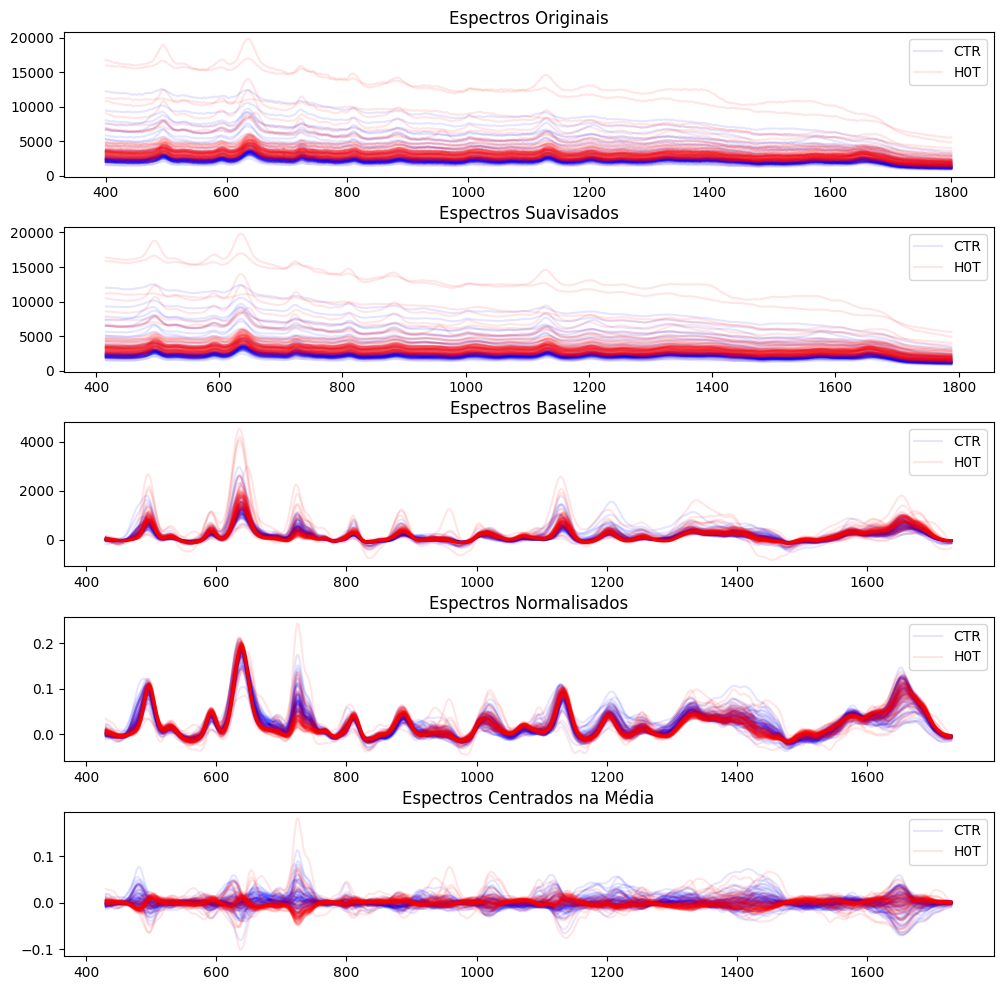

In [8]:
# plot do histórico do pré tratamento de dados
index_CTR = cabecario[cabecario["class"] == "CTR"].index
index_HOT = cabecario[cabecario["class"] == "H0T"].index

figura, axes = plt.subplots(5,1,figsize = (12,12))
figura.subplots_adjust(hspace = 0.35)

for i in index_CTR:
  axes[0].plot(df.columns, df.loc[i,:], color = "blue", alpha = 0.1, label = "CTR" if i == index_CTR[-1] else None)
for i in index_HOT:
  axes[0].plot(df.columns, df.loc[i,:], color = "red", alpha = 0.1, label = "H0T" if i == index_HOT[-1] else None )

for i in index_CTR:
  axes[1].plot(df_suave.columns, df_suave.loc[i,:], color = "blue", alpha = 0.1, label = "CTR" if i == index_CTR[-1] else None)
for i in index_HOT:
  axes[1].plot(df_suave.columns, df_suave.loc[i,:], color = "red", alpha = 0.1, label = "H0T" if i == index_HOT[-1] else None )

for i in index_CTR:
  axes[2].plot(df_base.columns, df_base.loc[i,:], color = "blue", alpha = 0.1, label = "CTR" if i == index_CTR[-1] else None)
for i in index_HOT:
  axes[2].plot(df_base.columns, df_base.loc[i,:], color = "red", alpha = 0.1, label = "H0T" if i == index_HOT[-1] else None )

for i in index_CTR:
  axes[3].plot(df_norm.columns, df_norm.loc[i,:], color = "blue", alpha = 0.1, label = "CTR" if i == index_CTR[-1] else None)
for i in index_HOT:
  axes[3].plot(df_norm.columns, df_norm.loc[i,:], color = "red", alpha = 0.1, label = "H0T" if i == index_HOT[-1] else None )

for i in index_CTR:
  axes[4].plot(df_centrado.columns, df_centrado.loc[i,:], color = "blue", alpha = 0.1, label = "CTR" if i == index_CTR[-1] else None)
for i in index_HOT:
  axes[4].plot(df_centrado.columns, df_centrado.loc[i,:], color = "red", alpha = 0.1, label = "H0T" if i == index_HOT[-1] else None )

axes[0].legend()
axes[0].set_title("Espectros Originais")
axes[1].legend()
axes[1].set_title("Espectros Suavisados")
axes[2].legend()
axes[2].set_title("Espectros Baseline")
axes[3].legend()
axes[3].set_title("Espectros Normalisados")
axes[4].legend()
axes[4].set_title("Espectros Centrados na Média")
plt.show()


7 - Analise preliminar das componentes principais para avaliar a variância explicada das primeiras componentes principais. Nota-se que as 10 primeiras componentes principais explicam mais de 95% da variância, entretanto não foi possível notar separação entre os grupos H0T (positivo para carcinoma) e CTR (controle - negativo para carcinoma) nos plots das 4 primeiras componentes principais.

Text(0.5, 1.0, 'Loadings 10 1ªs PCs')

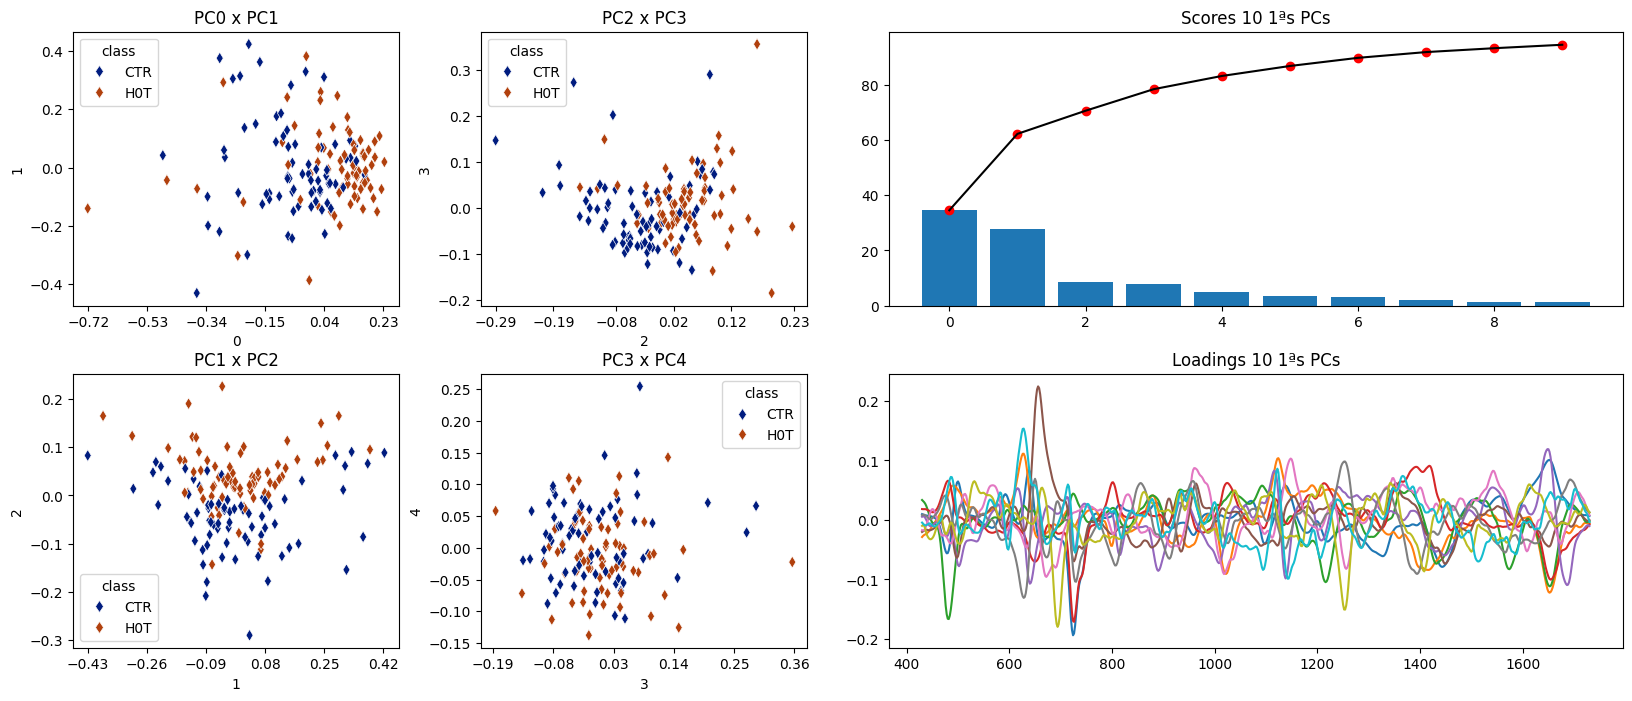

In [9]:
#resumo dos resultados obtidos com as componentes principais mais significantes
U, s, Vh = np.linalg.svd(df_centrado, full_matrices= False)
s_porcent = s**2 / ((s**2).sum())
s_cum = np.cumsum(s_porcent)
scores = U*s
df_scores = pd.DataFrame(scores)
df_scores["class"] = cabecario["class"]

gs = plt.GridSpec(2,4, hspace = 0.25, wspace = 0.25)

figura = plt.figure(figsize = (20,8))
ax1 = figura.add_subplot(gs[0,0])
ax2 = figura.add_subplot(gs[1,0])
ax3 = figura.add_subplot(gs[0,1])
ax4 = figura.add_subplot(gs[1,1])

sns.scatterplot(data = df_scores, x = 0, y = 1, hue = "class", ax = ax1, palette = "dark", marker = "d")
ticks1 = np.linspace(df_scores.iloc[:,0].min(), df_scores.iloc[:,0].max(), 6)
ax1.set_xticks(ticks1.round(2))
ax1.set_title("PC0 x PC1")

sns.scatterplot(data = df_scores, x = 1, y = 2, hue = "class", ax = ax2, palette = "dark", marker = "d")
ticks2 = np.linspace(df_scores.iloc[:,1].min(), df_scores.iloc[:,1].max(), 6)
ax2.set_xticks(ticks2.round(2))
ax2.set_title("PC1 x PC2")

sns.scatterplot(data = df_scores, x = 2, y = 3, hue = "class", ax = ax3, palette = "dark", marker = "d")
ticks3 = np.linspace(df_scores.iloc[:,2].min(), df_scores.iloc[:,2].max(), 6)
ax3.set_xticks(ticks3.round(2))
ax3.set_title("PC2 x PC3")

sns.scatterplot(data = df_scores, x = 3, y = 4, hue = "class", ax = ax4, palette = "dark", marker = "d")
ticks4 = np.linspace(df_scores.iloc[:,3].min(), df_scores.iloc[:,3].max(), 6)
ax4.set_xticks(ticks4.round(2))
ax4.set_title("PC3 x PC4")

ax5 = figura.add_subplot(gs[0,2:])
ax5.bar(range(0,10), s_porcent[0:10]*100 )
ax5.plot(range(0,10), s_cum[0:10]*100, color = "black")
ax5.scatter(range(0,10), s_cum[0:10]*100, color = "red")
ax5.set_title("Scores 10 1ªs PCs")

ax6 = figura.add_subplot(gs[1,2:])
for i in Vh[0:10]:
  ax6.plot(df_centrado.columns, i)
ax6.set_title("Loadings 10 1ªs PCs")

8 - Analise preliminar de discriminantes lineares. Para o Cálculo da LDA, utilizou-se as 10 primeiros scores obtidos no tratamento anterior. Totase que a discriminante obtida entrega separação muito melhor entre os grupos positivos para carcinoma e controle. Logo, uma análise de LDA mais rigorosa deve otimizar a classificação e entregar um bom modelo de discriminação.

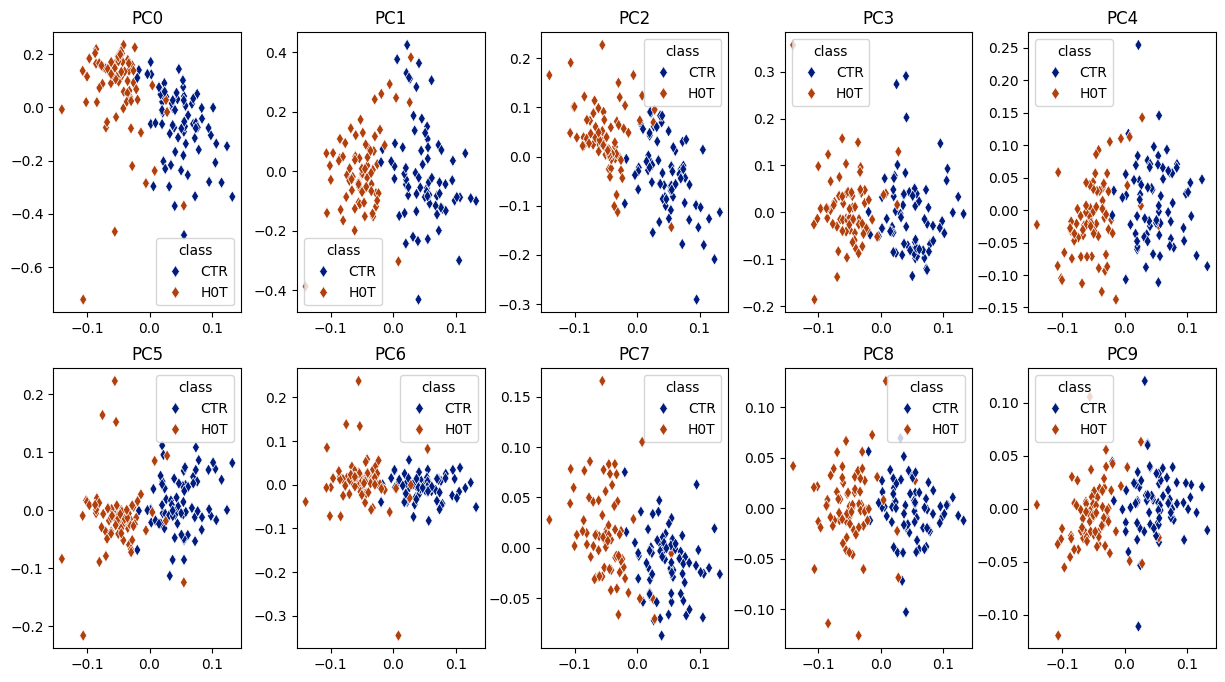

In [11]:
# tratamento de dados preliminar com LDA e plot dos resultados
Sb, Sw, LDA = eg.LDAcalc(df_scores, "class", list(range(0,10)))
w = LDA.iloc[0,:]

LDA_teste = df_scores.iloc[:,0:10].dot(w)

df_teste = df_scores.iloc[:,0:10].copy()
df_teste["class"] = df_scores["class"]
df_teste["LDA"] = LDA_teste.values


figura, axis = plt.subplots(2,5, figsize = (15,8))
figura.subplots_adjust(wspace = 0.3)

sns.scatterplot(data = df_teste, x = "LDA", y = 0, hue = "class", ax = axis[0,0], palette = "dark", marker = "d")
sns.scatterplot(data = df_teste, x = "LDA", y = 1, hue = "class", ax = axis[0,1], palette = "dark", marker = "d")
sns.scatterplot(data = df_teste, x = "LDA", y = 2, hue = "class", ax = axis[0,2], palette = "dark", marker = "d")
sns.scatterplot(data = df_teste, x = "LDA", y = 3, hue = "class", ax = axis[0,3], palette = "dark", marker = "d")
sns.scatterplot(data = df_teste, x = "LDA", y = 4, hue = "class", ax = axis[0,4], palette = "dark", marker = "d")
sns.scatterplot(data = df_teste, x = "LDA", y = 5, hue = "class", ax = axis[1,0], palette = "dark", marker = "d")
sns.scatterplot(data = df_teste, x = "LDA", y = 6, hue = "class", ax = axis[1,1], palette = "dark", marker = "d")
sns.scatterplot(data = df_teste, x = "LDA", y = 7, hue = "class", ax = axis[1,2], palette = "dark", marker = "d")
sns.scatterplot(data = df_teste, x = "LDA", y = 8, hue = "class", ax = axis[1,3], palette = "dark", marker = "d")
sns.scatterplot(data = df_teste, x = "LDA", y = 9, hue = "class", ax = axis[1,4], palette = "dark", marker = "d")

axis[0,0].set(xlabel = (""), ylabel = (""), title = "PC0")
axis[0,1].set(xlabel = (""), ylabel = (""), title = "PC1")
axis[0,2].set(xlabel = (""), ylabel = (""), title = "PC2")
axis[0,3].set(xlabel = (""), ylabel = (""), title = "PC3")
axis[0,4].set(xlabel = (""), ylabel = (""), title = "PC4")
axis[1,0].set(xlabel = (""), ylabel = (""), title = "PC5")
axis[1,1].set(xlabel = (""), ylabel = (""), title = "PC6")
axis[1,2].set(xlabel = (""), ylabel = (""), title = "PC7")
axis[1,3].set(xlabel = (""), ylabel = (""), title = "PC8")
axis[1,4].set(xlabel = (""), ylabel = (""), title = "PC9")
plt.show()
